In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import bernoulli_experiments_lib as bern_lib

In [2]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [3]:
import torch

In [4]:
np.random.seed(4524)
_ = torch.manual_seed(4524)

We are interested in minimizing an objective of the form 
\begin{align}
E_{q_\eta(z)}[f(z)]
\end{align}
where $z$ is a discrete random variable, so the re-parametrization trick does not apply. 

We consider a simple experiment, and examine the performance of REINFORCE, ARM, and a new proposed method. 


# The setup: 

We seek to minimize the loss function: 
\begin{align}
E_{b} \|b - p_0\|^2
\end{align}
where $b\in \{0, 1\}^d$, and each element $b_i \sim^{iid} \text{Bernoulli}(\sigma(\phi))$. We optimize over $\phi\in\mathbb{R}^n$; $\sigma(\cdot)$ is the sigmoid function. 

In [5]:
# fixed parameters
# p0 = torch.rand(d)
p0 = torch.Tensor([0.6, 0.51, 0.48])

d = len(p0)
print('p0: ', p0, '\n')

print('sum(p0^2): ', torch.sum(p0**2))
print('sum((1 - p0)^2): ', torch.sum((1 - p0)**2), '\n')


p0:  tensor([ 0.6000,  0.5100,  0.4800]) 

sum(p0^2):  tensor(0.8505)
sum((1 - p0)^2):  tensor(0.6705) 



We can re-write the objective as 

\begin{align}
f(\phi) = \sum_{i=1}^d \Big\{\sigma(\phi) (1 - p_{0i})^2 + (1 - \sigma(\phi)) p_{0i}^2\Big\}
\end{align}

If $\sum_{i=1}^d(1 - p_{0i})^2 > \sum_{i=1}^d p_{0i}^2$, then the optimal $\sigma(\phi)$ is 1; otherwise, 
the optimal $\sigma(\phi)$ is 0. 

In [6]:
# the optima
x_optimal = torch.argmin(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

optimal_loss = torch.min(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

print('optimal loss: ', optimal_loss)
print('optimal x: ', x_optimal.numpy())

optimal loss:  tensor(0.6705)
optimal x:  1


# Set up experiment class

In [7]:
init = -4.0

In [8]:
# init for phi
phi0 = torch.Tensor([init])# torch.rand(1, requires_grad=True)
phi0.requires_grad_(True)
print('init: ', phi0)

init:  tensor([-4.])


In [9]:
bern_experiment = bern_lib.BernoulliExperiments(p0, d, deepcopy(phi0))

In [10]:
class BernLossClass(object): 
    def __init__(self, bern_experiment, alpha, topk, use_baseline): 
        self.bern_experiment = bern_experiment
        self.alpha = alpha
        self.topk = topk
        self.use_baseline = use_baseline

    def get_loss(self): 
        return self.bern_experiment.get_pm_loss(alpha=self.alpha, 
                                           topk=self.topk, 
                                           use_baseline=self.use_baseline)


# Train with true gradient

We can compute the gradient of $f(\phi)$, and do simple gradient descent. 

In [11]:
n_steps = 1000
lr = 1.0

loss_array_true_grad, opt_param = pm_lib.run_SGD(get_loss = bern_experiment.get_full_loss, 
                params = bern_experiment.var_params,
                lr = lr, 
                n_steps = n_steps)

Text(0,0.5,'loss')

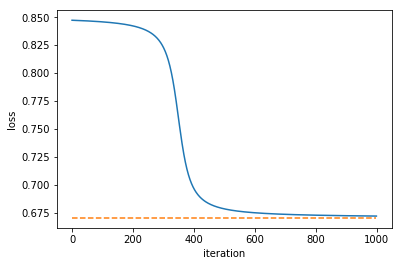

In [12]:
plt.plot(loss_array_true_grad)

# orange line is true optimal loss
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

plt.xlabel('iteration')
plt.ylabel('loss')

In [13]:
# assert we actually descended at each step
for i in range(1, n_steps): 
    assert (loss_array_true_grad[i] - loss_array_true_grad[i-1]) <= 0

In [14]:
print('phi_final: ', opt_param['phi'])
print('x_final: ', sigmoid(torch.Tensor(opt_param['phi'].detach())).numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  tensor([ 4.6833])
x_final:  [0.990836]
x_optimal:  1


# Train with reinforce gradient

Alternatively, we could evaluate stochastic gradients. The first that we consider here, is the REINFORCE estimator. 

We estimate the gradient as 
\begin{align}
g(\phi) = \|b - p_0\|^2 \nabla_\phi \log P_\phi(b), \quad b\sim P_\phi(b)
\end{align}

where $P_\phi(b) = \sigma(\phi)^{\sum b} \cdot (1 - \sigma(\phi))^{1 -\sum b}$, the probability of observing a vector $b$, when its components $b_i$ are drawn iid from $\text{Bernoulli}(\sigma(\phi))$. 
 
 We expect this gradient to have high variance. 

In [15]:
phi0 = torch.Tensor([init])
phi0.requires_grad_(True)
bern_experiment.set_var_params(phi0)

    
bern_loss_class = BernLossClass(bern_experiment, alpha = 0.0, topk = 0, use_baseline = False)

loss_array_reinforce, opt_param = pm_lib.run_SGD(
                get_loss = bern_loss_class.get_loss, 
                params = bern_experiment.var_params,
                lr = lr, 
                n_steps = n_steps, 
                get_full_loss = bern_experiment.get_full_loss)

Text(0,0.5,'loss')

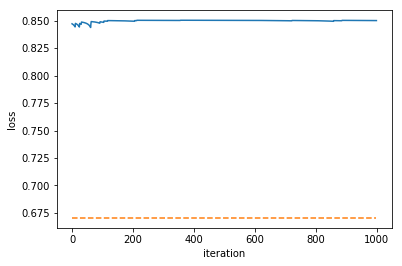

In [16]:
plt.plot(loss_array_reinforce)
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

plt.xlabel('iteration')
plt.ylabel('loss')

In [17]:
print('phi_final: ', opt_param['phi'])
print('x_final: ', sigmoid(torch.Tensor(opt_param['phi'])).detach().numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  tensor([-5.9766])
x_final:  [0.00253097]
x_optimal:  1


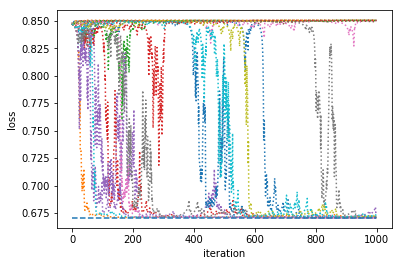

In [18]:
for i in range(20): 
    
    phi0 = torch.Tensor([init])# torch.rand(1, requires_grad=True)
    phi0.requires_grad_(True)
    bern_experiment.set_var_params(phi0)


    loss_array_reinforce, opt_param = pm_lib.run_SGD(
                    get_loss = bern_loss_class.get_loss, 
                    params = bern_experiment.var_params,
                    lr = lr, 
                    n_steps = n_steps, 
                    get_full_loss = bern_experiment.get_full_loss)

    plt.plot(loss_array_reinforce, ':')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


Indeed, it does not even always converge to the truth. 

# Partial marginalization

This is the method we propose. In general, suppose our loss function is of the form 
\begin{align}
E_{q_\eta(z)}[f(z)]
\end{align}
and $z\in\{0, ..., K\}$ is discrete. 

The objective can be written as
\begin{align}
E_{q_\eta(z)}[f(z)] = \sum_{k = 1}^K q_\eta(z = k) f(k)
\end{align}

But in many cases, $K$ is large (think SBN, for example, were the latent space of dimension $d$ can take $2^d$ distinct values), and evaluating $f(z)$ is expensive. REINFORCE gets around this problem by sampling, only one $z$ at each iteration, but as we saw, it has much too high variance. 

If we call computing the sum over $z$ and taking gradients the ``classic" method (as its common in the old VAE) literature, we propose a combination of REINFORCE and this classic method that may potentially have smaller variance. 

More formally, let $\mathcal{C}_\alpha = \{z : q_\eta(z) > \alpha\}$, the set where $q_\eta(z)$ has mass greater than some value $\alpha$, and $1 \{z\in \mathcal{C}_\alpha\}$ be the indicator that $z\in\mathcal{C}_\alpha$. We write

\begin{align}
 E_{q_\eta(z)}[f(z)] &=
 E_{q_\eta(z)}[f(z) 1\{z \in \mathcal{C}_\alpha\} + f(z) 1\{z \not\in \mathcal{C}_\alpha\}] \\
&= \sum_{z\in\mathcal{C}_\alpha}q_\eta(z) f(z) + E_{q_\eta(z)}[f(z)1\{z \not\in \mathcal{C}_\alpha\}]
\end{align}

In other words, we sum over the first $k$ largest probabilities. To take the gradient, we use the analytic gradient for the first term; and for the second term we apply the REINFORCE estimator (or any other stochastic gradient estimator). 

Intuitively, we think this is a good idea because we would expect that the mass of $z$ to be concentrated around a few points -- so we simply sum those out. For the remainder, we use the REINFORCE estimator to compute the gradient of the expectation; note that this expecation is scaled by $q_\eta(z > k)$, which we said are the small probabilities, so this factor will control the variance. 

### Lets experiment with the number reinforced

In [19]:
def get_avg_paths(phi0, bern_experiment, n_summed, n_trials = 20, n_steps = 1000, lr = 1, use_baseline = False): 
    # Function to run a few trials of SGD and get the average path 
    
    loss_path_all = np.zeros((n_trials, n_steps))
    
    for i in range(n_trials): 
        
        phi0.requires_grad_(True)
        bern_experiment.set_var_params(phi0)
        
        bern_loss_class = BernLossClass(bern_experiment, alpha = 0.0, topk = n_summed, 
                                        use_baseline = use_baseline)

        loss_path, _ = pm_lib.run_SGD(
                        get_loss = bern_loss_class.get_loss, 
                        params = bern_experiment.var_params,
                        lr = lr, 
                        n_steps = n_steps, 
                        get_full_loss = bern_experiment.get_full_loss)
            
        loss_path_all[i, :] = loss_path
    
    loss_array_avg = np.mean(loss_path_all, axis = 0)
    
    return loss_array_avg, loss_path_all


0
1
3
8


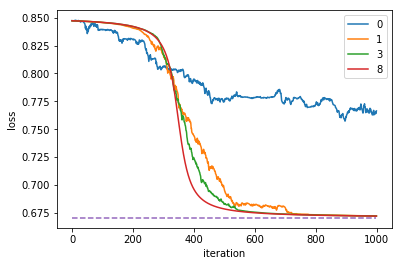

In [20]:
lr = 1
n_steps = 1000

n_summed_array = [0, 1, 3, 8]

avg_loss_num_reinforce_array = np.zeros((len(n_summed_array), n_steps))

for i in range(len(n_summed_array)): 
    n_summed = n_summed_array[i]
    print(n_summed)
    
    phi0 = torch.Tensor([init])
    
    avg_loss_array, _ = \
        get_avg_paths(phi0, bern_experiment, n_summed = n_summed, lr = lr, n_steps = n_steps)
        
    avg_loss_num_reinforce_array[i, :] = avg_loss_array
        
    plt.plot(avg_loss_array, '-')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.legend(('0', '1', '3', '8'))

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


In [21]:
fontsize = 18

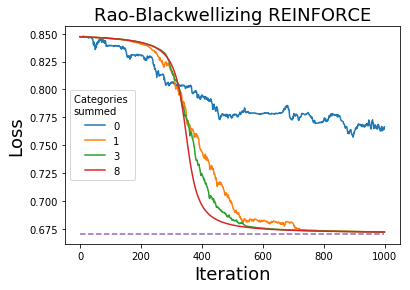

In [22]:
plt.plot(avg_loss_num_reinforce_array.T, '-')

plt.xlabel('Iteration', fontsize = fontsize)
plt.ylabel('Loss', fontsize = fontsize)
plt.title('Rao-Blackwellizing REINFORCE', fontsize = fontsize)

plt.legend(('0', '1', '3', '8'), title = 'Categories \nsummed')

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

# plt.savefig('../../writing/AISTATS_results_figures/bernoulli_reinforce_paths.png')

Now note that for the second term of the partial marginalization procedure, we can choose any stochastic gradient estimator we want. We can try REINFORCE with a control variate

# REINFORCE with control variate

Recall that our REINFORCE estimator looks like
\begin{align}
    f(z)\nabla_\eta \log q_\eta(z) \quad z \sim q_\eta(z)
\end{align}
and this is an unbiased estimator for $\nabla_\eta E_{q_\eta(z)}[f(z)]$. 

Since $E_{q_\eta(z)}[\nabla_\eta\log q_\eta(z)] = 0$, we can subtract any quantity $C$ from $f(z)$, independent of $z$, and 
\begin{align}
(f(z) - C)\nabla_\eta \log q_\eta(z) \quad z \sim q_\eta(z)
\end{align}
is still an unbiased estimator for the gradient. The goal is to pick a $C$ that reduces the variance of the REINFORCE estimator. 

One simple choice is to draw a $z' \sim q_\eta(z)$ independent from $z$ and evaluate $f(z')$ as our control variate. In this case, our estimator is 

\begin{align}
    [f(z) - f(z')]\nabla_\eta \log q_\eta(z) \quad z, z' \sim q_\eta(\cdot), \text{ independent}
\end{align}


In [23]:
bern_experiment.set_var_params(phi0)

bern_loss_class = BernLossClass(bern_experiment, alpha = 0.0, topk = 2, use_baseline = True)

loss_array_reinforce_bl, opt_param = pm_lib.run_SGD(
                get_loss = bern_loss_class.get_loss, 
                params = bern_experiment.var_params,
                lr = lr, 
                n_steps = n_steps, 
                get_full_loss = bern_experiment.get_full_loss)

In [24]:
# lr = 1
# n_steps = 500

# phi0 = torch.Tensor([init])
# phi0.requires_grad_(True)
# obj_class_reinforce.experiment_class.set_var_params(phi0)

# phi_opt_reinforce_bl, loss_array_reinforce_bl = \
#         obj_class_reinforce.run_SGD(alpha =  0.0, 
#                                     topk = 0, 
#                                     lr = lr, 
#                                     n_steps = n_steps, 
#                                    use_baseline = True)

Text(0,0.5,'loss')

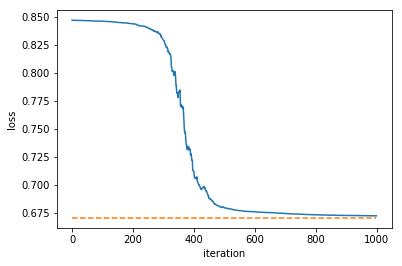

In [25]:
plt.plot(loss_array_reinforce_bl)
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

plt.xlabel('iteration')
plt.ylabel('loss')

In [26]:
print('phi_final: ', opt_param['phi'])
print('x_final: ', sigmoid(torch.Tensor([opt_param['phi']])).numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  tensor([ 4.5601])
x_final:  [0.98964745]
x_optimal:  1


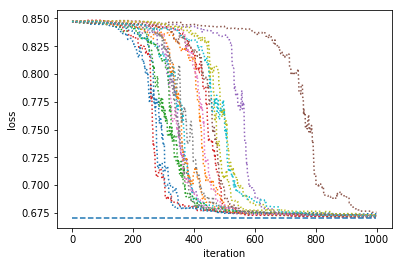

In [27]:
for i in range(20):
    
    phi0 = torch.Tensor([init])
    phi0.requires_grad_(True)
    bern_experiment.set_var_params(deepcopy(phi0))
    
    bern_loss_class = BernLossClass(bern_experiment, alpha = 0.0, topk = 0, use_baseline = True)

    loss_array_reinforce_bl, opt_param = pm_lib.run_SGD(
                    get_loss = bern_loss_class.get_loss, 
                    params = bern_experiment.var_params,
                    lr = lr, 
                    n_steps = n_steps, 
                    get_full_loss = bern_experiment.get_full_loss)

    plt.plot(loss_array_reinforce_bl, ':')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


The control variate helps, and REINFORCE works a lot better. Does doing partial marginalization help here?

0
1
3
8


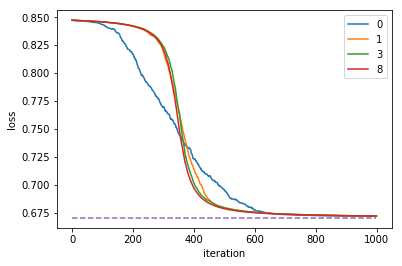

In [28]:
lr = 1
n_steps = 1000

n_summed_array = [0, 1, 3, 8]

avg_loss_num_reinforce_bl_array = np.zeros((len(n_summed_array), n_steps))

for i in range(len(n_summed_array)): 
    n_summed = n_summed_array[i]
    print(n_summed)
    
    phi0 = torch.Tensor([init])
    
    avg_loss_array, _ = \
        get_avg_paths(phi0, bern_experiment, n_summed = n_summed, lr = lr, n_steps = n_steps, use_baseline = True)
        
    avg_loss_num_reinforce_bl_array[i, :] = avg_loss_array
        
    plt.plot(avg_loss_array, '-')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.legend(('0', '1', '3', '8'))

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


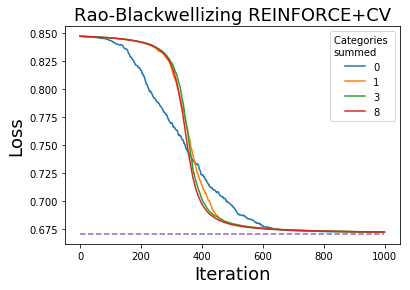

In [31]:
plt.plot(avg_loss_num_reinforce_bl_array.T, '-')

plt.xlabel('Iteration', fontsize = fontsize)
plt.ylabel('Loss', fontsize = fontsize)
plt.title('Rao-Blackwellizing REINFORCE+CV', fontsize = fontsize)

plt.legend(('0', '1', '3', '8'), title = 'Categories \nsummed')

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')
plt.savefig('../../writing/AISTATS_results_figures/bernoulli_reinforce_bl_paths.png')

In [41]:
fontsize

18